Objectives:

Data Cleaning & Transformation:
Clean the dataset by handling missing values, duplicates, and outliers, preparing it for effective clustering.

Feature Engineering:
Develop new features based on the transactional data to create a customer-centric dataset, setting the foundation for customer segmentation.

Data Preprocessing:
Undertake feature scaling and dimensionality reduction to streamline the data, enhancing the efficiency of the clustering process.

Customer Segmentation using K-Means Clustering:
Segment customers into distinct groups using K-means, facilitating targeted marketing and personalized strategies.

Cluster Analysis & Evaluation:
Analyze and profile each cluster to develop targeted marketing strategies and assess the quality of the clusters formed.

Recommendation System:
Implement a system to recommend best-selling products to customers within the same cluster who haven't purchased those products, aiming to boost sales and marketing effectiveness.

Step 1 | Setup and Initialization

Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import pearsonr
from scipy.sparse import csr_matrix
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

Loading the Dataset

In [2]:
df = pd.read_csv(r"C:\Users\Niti\NEXT HIKES\PROJECT 8\all_upwork_jobs_2024-02-07-2024-03-24.csv")

Dataset Description:

In [3]:
df.describe()

,hourly_low,hourly_high,budget
count,102422.000000,98775.000000,103891.000000
mean,17.339644,41.970610,911.473564
std,18.140065,47.850892,15729.738834
min,3.000000,3.000000,5.000000
25%,8.000000,20.000000,25.000000
50%,15.000000,30.000000,100.000000
75%,20.000000,50.000000,300.000000
max,998.000000,999.000000,1000000.000000


Step 2 | Initial Data Analysis

In [4]:
df.head(2)

,title,link,published_date,is_hourly,hourly_low,hourly_high,budget,country
0,Experienced Media Buyer For Solar Pannel and R...,https://www.upwork.com/jobs/Experienced-Media-...,2024-02-17 09:09:54+00:00,False,NaN,NaN,500.0,NaN
1,Full Stack Developer,https://www.upwork.com/jobs/Full-Stack-Develop...,2024-02-17 09:09:17+00:00,False,NaN,NaN,1100.0,United States


In [5]:
df.shape

(244828, 8)

In [6]:
df.isnull().sum()

title                  1
link                   1
published_date         0
is_hourly              0
hourly_low        142406
hourly_high       146053
budget            140937
country             5077
dtype: int64

Step 3 | Data Cleaning & Transformation

Handling Missing values

In [7]:
# Filling title with unknown
df['title'].fillna('Unknown',inplace=True)

# Filling link with unknown
df['link'].fillna('Unknown',inplace=True)

# Filling hourly_low with mean
df['hourly_low'].fillna(df['hourly_low'].mean(), inplace=True)

# Filling hourly_high with mean
df['hourly_high'].fillna(df['hourly_high'].mean(), inplace=True)

# Filling budget with mean
df['budget'].fillna(df['budget'].mean(), inplace=True)

# Filling country with Unknown
df['country'].fillna('Unknown',inplace=True)

In [8]:
df.isnull().sum()

title             0
link              0
published_date    0
is_hourly         0
hourly_low        0
hourly_high       0
budget            0
country           0
dtype: int64

Summary Statistics

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244828 entries, 0 to 244827
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   title           244828 non-null  object 
 1   link            244828 non-null  object 
 2   published_date  244828 non-null  object 
 3   is_hourly       244828 non-null  bool   
 4   hourly_low      244828 non-null  float64
 5   hourly_high     244828 non-null  float64
 6   budget          244828 non-null  float64
 7   country         244828 non-null  object 
dtypes: bool(1), float64(3), object(4)
memory usage: 13.3+ MB


In [10]:
df.columns

Index(['title', 'link', 'published_date', 'is_hourly', 'hourly_low',
       'hourly_high', 'budget', 'country'],
      dtype='object')

Task 1: Analyze the correlation between job title keywords and offered salaries

●	Objective: To find patterns between the keywords in job titles and the corresponding salaries offered.

●	Deliverables: A report detailing the correlation, supported by statistical analysis and visualizations.


In [11]:
# calculating average salary
df['avg_salary'] = (df['hourly_low'] + df['hourly_high']) /2

In [12]:
# extracting keywords from job titles
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['title'])
keywords = vectorizer.get_feature_names_out()


In [13]:
# Creating a sparse DataFrame for the keyword matrix
keyword_df = pd.DataFrame.sparse.from_spmatrix(X, columns=keywords)
keyword_df['avg_salary'] = df['avg_salary'].values


In [14]:
# Correlation analysis
correlation_results = {}
for keyword in keywords:
    if keyword in keyword_df.columns:
        correlation, _ = pearsonr(X[:, keywords.tolist().index(keyword)].toarray().ravel(), df['avg_salary'])
        correlation_results[keyword] = correlation

# Convert correlation results to DataFrame
correlation_df = pd.DataFrame(list(correlation_results.items()), columns=['Keyword', 'Correlation'])

# Sort by absolute correlation value for better visualization
correlation_df['AbsCorrelation'] = correlation_df['Correlation'].abs()
correlation_df = correlation_df.sort_values(by='AbsCorrelation', ascending=False).drop(columns=['AbsCorrelation'])


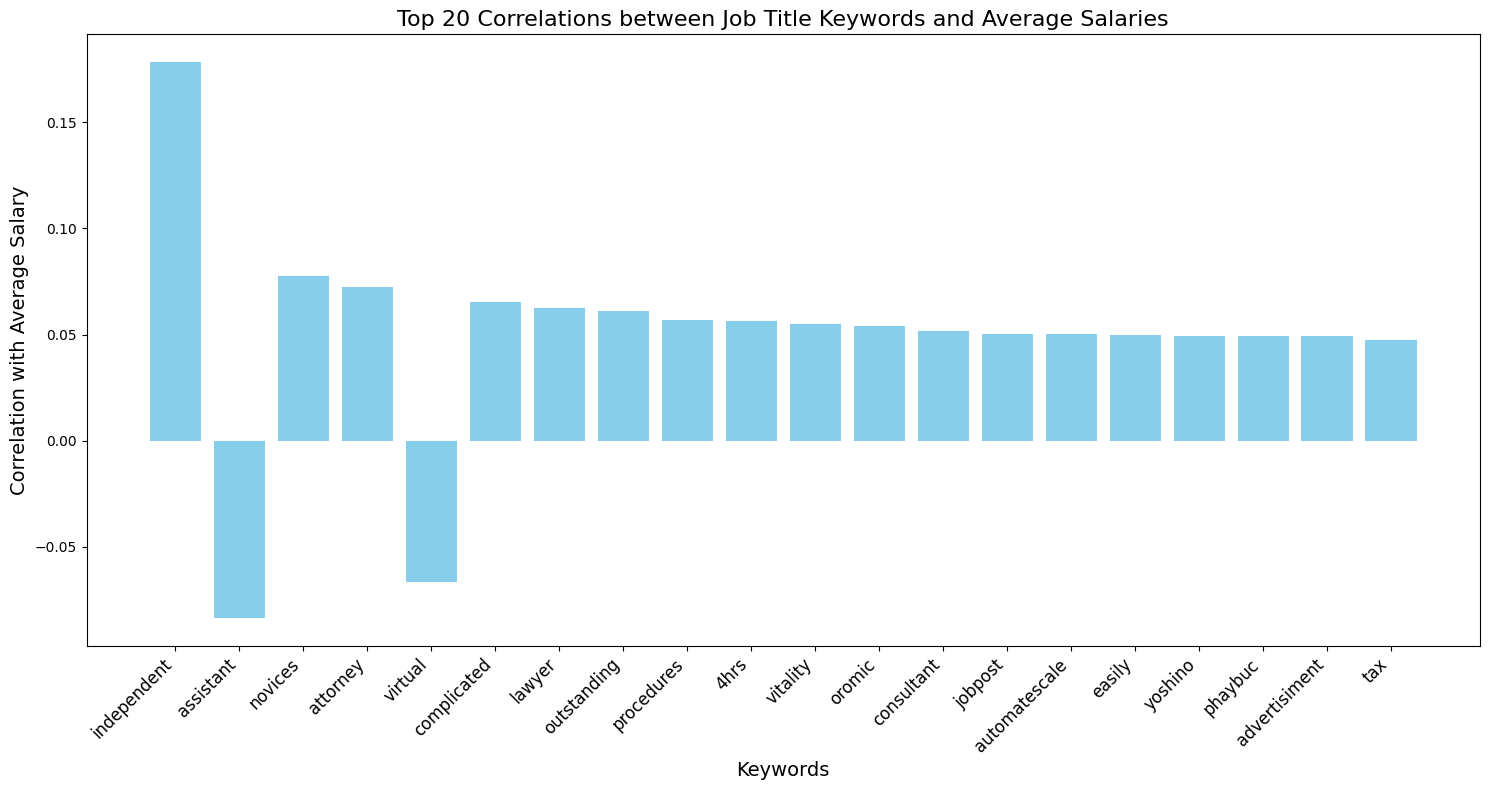

In [17]:
# Plot the top 20 keywords by absolute correlation
top_n = 20
correlation_df_top = correlation_df.head(top_n)

plt.figure(figsize=(15, 8))
plt.bar(correlation_df_top['Keyword'], correlation_df_top['Correlation'], color='skyblue')
plt.xlabel('Keywords', fontsize=14)
plt.ylabel('Correlation with Average Salary', fontsize=14)
plt.title('Top 20 Correlations between Job Title Keywords and Average Salaries', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()

# Save and show the plot
plt.savefig('correlation_plot.png', dpi=300)
plt.show()

# Save the report
report = correlation_df.to_string(index=False)
with open('correlation_report.txt', 'w') as file:
    file.write(report)

Task 2: Identify emerging job categories based on posting frequency

●	Objective: To identify new and emerging job categories by analyzing the frequency and trend of job postings.

●	Deliverables: A list of emerging job categories with growth analysis over time.


In [18]:
df['title'].unique()

array(['Experienced Media Buyer For Solar Pannel and Roofing installation companies.',
       'Full Stack Developer', 'SMMA Bubble App', ...,
       'Digital/Telemarketing/Sales/OutSide Sales',
       'ELEMENTOR PRO For quick fix (Wordpress)',
       'Creating a UGC Ad for Our Mobile Game'], dtype=object)

In [19]:
# Converting published_date to datetime format
df['published_date'] = pd.to_datetime(df['published_date'], errors='coerce')

# Droping rows with invalid dates
df = df.dropna(subset=['published_date'])

In [20]:
# Extracting job categories (this can be refined based on your actual data)
def categorize_job(title):
    if 'Data' in title:
        return 'Data'
    elif 'Software' in title or 'Engineer' in title:
        return 'Engineering'
    elif 'Project' in title:
        return 'Project Management'
    elif 'Developer' in title:
        return 'Full Stack Developer'
    else:
        return 'Other'

df['category'] = df['title'].apply(categorize_job)

In [21]:
# Resampling data by month
df['month'] = df['published_date'].dt.to_period('M')
monthly_counts = df.groupby(['month', 'category']).size().unstack(fill_value=0)

# Calculate growth rates
growth_rates = monthly_counts.pct_change().fillna(0)

# Identify emerging categories (example: categories with positive average growth rate)
average_growth = growth_rates.mean()
emerging_categories = average_growth[average_growth > 0].index

C:\Users\Niti\AppData\Local\Temp\ipykernel_15000\2319822746.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['published_date'].dt.to_period('M')


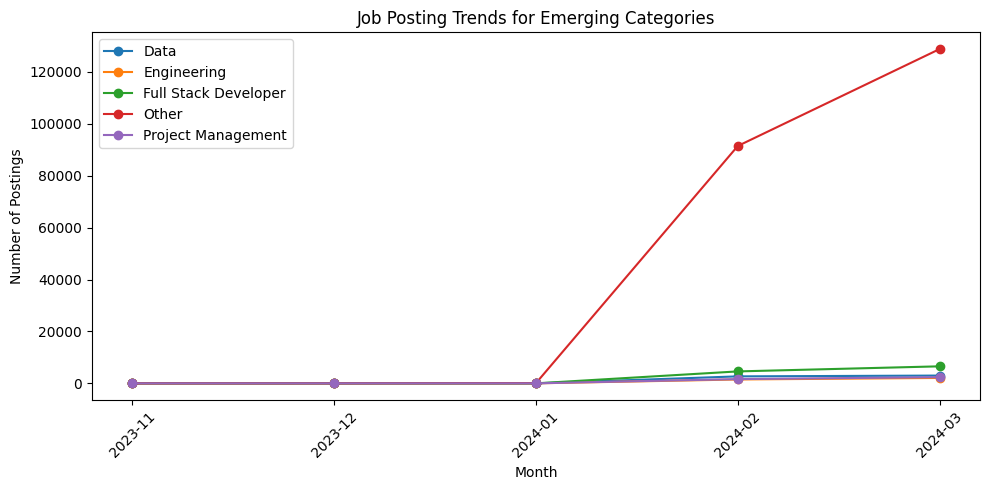

In [22]:
# Plotting trends for emerging categories
plt.figure(figsize=(10, 5))
for category in emerging_categories:
    plt.plot(monthly_counts.index.astype(str), monthly_counts[category], marker='o', label=category)

plt.xlabel('Month')
plt.ylabel('Number of Postings')
plt.title('Job Posting Trends for Emerging Categories')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Saving the report
emerging_categories_report = monthly_counts[emerging_categories]
emerging_categories_report.to_csv('emerging_categories_report.csv')

Task 3: Predict high-demand job roles by analyzing job posting patterns over time

●	Objective: To forecast high-demand job roles based on historical job posting data.

●	Deliverables: A predictive model with accuracy metrics, and a visual representation of demand trends over time.


In [23]:
# Forecasting function for each category
def forecast_category(category, data):
    if len(data) < 24:
        print(f"Not enough data for seasonal decomposition for category: {category}")
        return None, None, None
    
    # Split data into train and test sets
    train_data = data[:-12]
    test_data = data[-12:]
    
    # Fit the model
    model = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=12).fit()

    # Make predictions
    predictions = model.forecast(12)
    
    # Calculate RMSE
    rmse = mean_squared_error(test_data, predictions, squared=False)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data, label='Train')
    plt.plot(test_data.index, test_data, label='Test')
    plt.plot(predictions.index, predictions, label='Forecast')
    plt.xlabel('Date')
    plt.ylabel('Number of Postings')
    plt.title(f'Forecast for {category} (RMSE: {rmse:.2f})')
    plt.legend()
    plt.show()
    
    return model, predictions, rmse

# Apply forecasting to each category
results = {}
for category in monthly_counts.columns:
    model, predictions, rmse = forecast_category(category, monthly_counts[category])
    if model:
        results[category] = {'model': model, 'predictions': predictions, 'rmse': rmse}

# Summary of results
for category, result in results.items():
    print(f"Category: {category}, RMSE: {result['rmse']:.2f}")

# Save the models and results
import pickle
with open('forecast_models.pkl', 'wb') as f:
    pickle.dump(results, f)
    

Not enough data for seasonal decomposition for category: Data
Not enough data for seasonal decomposition for category: Engineering
Not enough data for seasonal decomposition for category: Full Stack Developer
Not enough data for seasonal decomposition for category: Other
Not enough data for seasonal decomposition for category: Project Management


In [24]:
# Forecasting function for each category
def forecast_category(category, data):
    if len(data) < 24:
        print(f"Not enough data for forecasting for category: {category}")
        return None, None, None

    # Split data into train and test sets
    train_data = data[:-12]
    test_data = data[-12:]

    # Fit the ARIMA model
    model = ARIMA(train_data, order=(1, 1, 1))
    fitted_model = model.fit()

    # Make predictions
    predictions = fitted_model.forecast(steps=len(test_data))

    # Calculate RMSE
    rmse = mean_squared_error(test_data, predictions, squared=False)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data, label='Train')
    plt.plot(test_data.index, test_data, label='Test')
    plt.plot(test_data.index, predictions, label='Forecast')
    plt.xlabel('Date')
    plt.ylabel('Number of Postings')
    plt.title(f'Forecast for {category} (RMSE: {rmse:.2f})')
    plt.legend()
    plt.show()

    return fitted_model, predictions, rmse

# Apply forecasting to each category
results = {}
for category in monthly_counts.index:
    model, predictions, rmse = forecast_category(category, monthly_counts.loc[category])
    if model:
        results[category] = {'model': model, 'predictions': predictions, 'rmse': rmse}

# Summary of results
for category, result in results.items():
    print(f"Category: {category}, RMSE: {result['rmse']:.2f}")

# Save the models and results
import pickle
with open('forecast_models.pkl', 'wb') as f:
    pickle.dump(results, f)


Not enough data for forecasting for category: 2023-11
Not enough data for forecasting for category: 2023-12
Not enough data for forecasting for category: 2024-01
Not enough data for forecasting for category: 2024-02
Not enough data for forecasting for category: 2024-03


Data Preprocessing

In [25]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt


# Parse dates
df['published_date'] = pd.to_datetime(df['published_date'])

# Group by job title and month
df['month'] = df['published_date'].dt.to_period('M')
job_counts = df.groupby(['month', 'title']).size().reset_index(name='count')

# Convert 'month' back to datetime
job_counts['month'] = job_counts['month'].dt.to_timestamp()

# Inspect the grouped data
print(job_counts.head())


C:\Users\Niti\AppData\Local\Temp\ipykernel_15000\2165063890.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['published_date'].dt.to_period('M')


       month                                              title  count
0 2023-11-01                  Senior .NET Architect (Team Lead)      1
1 2023-12-01  Bookkeeping and Collections Agent (Full Time R...      1
2 2023-12-01              Data Science / Computer Vision expert      1
3 2023-12-01  I am looking for a research writer to make a s...      1
4 2023-12-01           Marketing expert to explode the internet      1


Preparing Time Series data

In [26]:
def prepare_time_series(df, job_title):
    ts_df = df[df['title'] == job_title][['month', 'count']].rename(columns={'month': 'ds', 'count': 'y'})
    return ts_df

# Example: Prepare data for 'Full Stack Developer'
job_title = 'Full Stack Developer'
ts_df = prepare_time_series(job_counts, job_title)

# Inspect the time series data
print(ts_df.head())

# Check for NaN values
print(ts_df.isna().sum())


               ds   y
30886  2024-02-01  56
130633 2024-03-01  80
ds    0
y     0
dtype: int64


Handling insufficient Data Points

In [27]:
if ts_df.shape[0] < 2 or ts_df['y'].isna().sum() > 0:
    print(f"Not enough data points for job title: {job_title}")
else:
    # Train and forecast
    model = Prophet()
    model.fit(ts_df)
    future = model.make_future_dataframe(periods=12, freq='M')  # Forecasting 12 months into the future
    forecast = model.predict(future)
    
    # Inspect the forecast
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


21:45:06 - cmdstanpy - INFO - Chain [1] start processing
21:45:07 - cmdstanpy - INFO - Chain [1] done processing


           ds        yhat  yhat_lower  yhat_upper
9  2024-10-31  281.930665  281.930645  281.930685
10 2024-11-30  306.758211  306.758187  306.758234
11 2024-12-31  332.413342  332.413314  332.413369
12 2025-01-31  358.068472  358.068441  358.068504
13 2025-02-28  381.240848  381.240812  381.240885


Forecasting using Prophet

Evaluating and Visualizing

Accuracy Metrics

C:\Users\Niti\AppData\Local\Temp\ipykernel_15000\1947775598.py:12: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['published_date'].dt.to_period('M')


Not enough data points for job title: Frontend developer urgently needed for a small task
Not enough data points for job title: Create a master project and sub projects along with a dashboard
Not enough data points for job title: Full-stack developer - Front end focus - Angular, Laravel &amp; CraftCMS - .NET highly regarded
Not enough data points for job title: TikTok Content Creator for a Web Application
Not enough data points for job title: Mobile App Design for Women Healthcare
Not enough data points for job title: Create Proposal Template in Canva
Not enough data points for job title: Design &amp; Model a Printable Bird Feeder


11:43:37 - cmdstanpy - INFO - Chain [1] start processing
11:43:38 - cmdstanpy - INFO - Chain [1] done processing


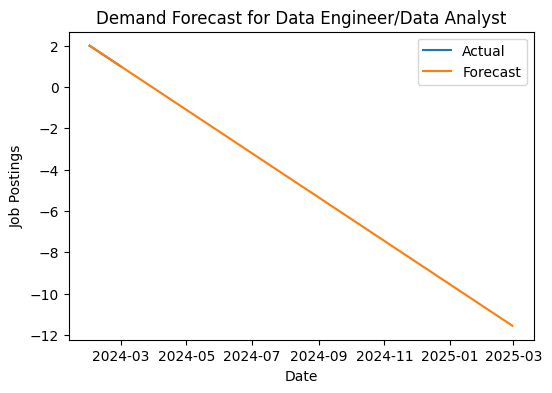

Not enough data points for proper training/testing split for job title: Data Engineer/Data Analyst
Not enough data points for job title: Shopify Expert Website Designer
Not enough data points for job title: Converting English text in our brand video to Mandarin text
Not enough data points for job title: Grant Writer for “Innovate UK” funding  ✍️
Not enough data points for job title: Bilingual VA, administrative needed for Chinese Mandarin and English
Not enough data points for job title: Etsy VA - Complete Listing Uploads &amp; Social Media Marketing
Not enough data points for job title: Experienced Thumbnail designer for crime niche YouTube videos
Not enough data points for job title: Looking for NodeJS Team To Develop Another Multiplayer Game
Not enough data points for job title: LinkedIn Profile Optimization and/or Lead Generation Specialist needed


11:43:38 - cmdstanpy - INFO - Chain [1] start processing
11:43:39 - cmdstanpy - INFO - Chain [1] done processing


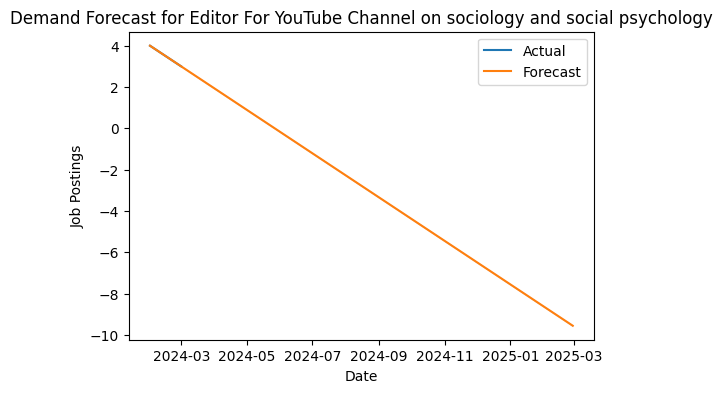

Not enough data points for proper training/testing split for job title: Editor For YouTube Channel on sociology and social psychology
Not enough data points for job title: Curate a personal, weekly newsletter that interests me
Not enough data points for job title: Systeme.io front end developer to setup design
Not enough data points for job title: Finishing 2023 year end and monthly bookeeeping moving forward. .   Currently using Xero
Not enough data points for job title: Travel agency owner
Not enough data points for job title: Concept, illustration, animation
Not enough data points for job title: Google My Business Setup
Not enough data points for job title: Ghost Writer for Business Leadership Book
Not enough data points for job title: Needed FullStack Developer with Javascript and Typescript Expereince
Not enough data points for job title: YOUTUBE SEO expert
Not enough data points for job title: Sales Development Representative to reach out to prospects and schedule calls
Not enoug

11:43:40 - cmdstanpy - INFO - Chain [1] start processing
11:43:40 - cmdstanpy - INFO - Chain [1] done processing


Not enough data points for job title: Media relations in Vienna Austria


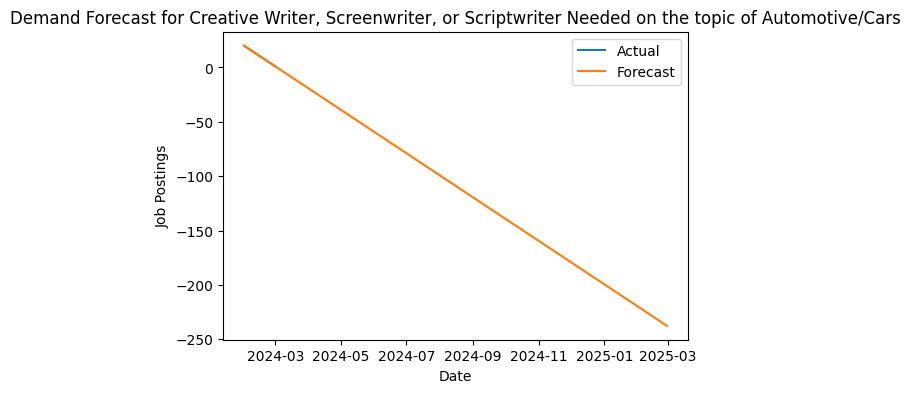

Not enough data points for proper training/testing split for job title: Creative Writer, Screenwriter, or Scriptwriter Needed on the topic of Automotive/Cars
Not enough data points for job title: Backend Development
Not enough data points for job title: Facebook ad specialist needed for leads
Not enough data points for job title: MixPost Pro Server Setup and Connect Socials
Not enough data points for job title: Videographer / Photographer Needed for 2 Day Musical Theatre Festival
Not enough data points for job title: Create a card deck in Canva for positive affirmations
Not enough data points for job title: Backlink and SEO expert needed
Not enough data points for job title: Desktop Application Developer, Taking All Applications
Not enough data points for job title: Components and single ticket view
Not enough data points for job title: Shopify Product Listings: Chatgpt + Seo Optimized Listings
Not enough data points for job title: Executive Director CDISP Search
Not enough data points

11:43:41 - cmdstanpy - INFO - Chain [1] start processing


Not enough data points for job title: Septic site location and strength
Not enough data points for job title: Copywriter/Creative Landing Page
Not enough data points for job title: RN Medical Assistant/Scribe with Hospital Experience
Not enough data points for job title: Real estate researcher


11:43:42 - cmdstanpy - INFO - Chain [1] done processing


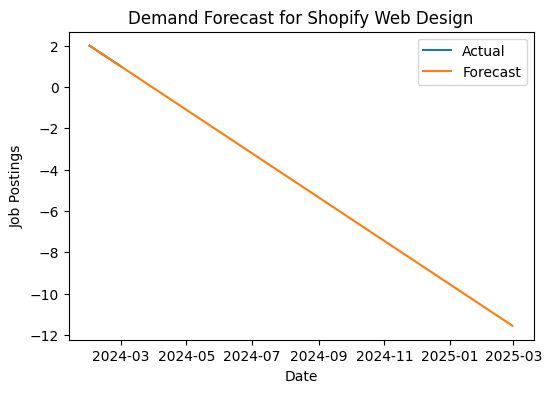

Not enough data points for proper training/testing split for job title: Shopify Web Design


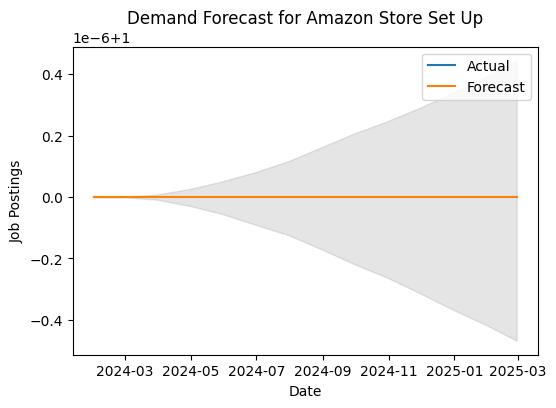

Not enough data points for proper training/testing split for job title: Amazon Store Set Up
Not enough data points for job title: Review for a PPC Campaign I am working on
Not enough data points for job title: Framer Custom Booking Component
Not enough data points for job title: Talking Head Style Video Editor
Not enough data points for job title: YouTube Script Writer (Financial)
Not enough data points for job title: GTmetrix Score Improvement for WooCommerce Website
Not enough data points for job title: Dubbing Artist Jobs - Japanese
Not enough data points for job title: Networking Lead Generator
Not enough data points for job title: Logo Creation from Rough Draft
Not enough data points for job title: Storyboard illustrator for video ad
Not enough data points for job title: Wechat post writing
Not enough data points for job title: Personal coaching
Not enough data points for job title: Remote High Ticket Setters and Closers
Not enough data points for job title: Translate phrases from

In [34]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np
import random

# Parse dates
df['published_date'] = pd.to_datetime(df['published_date'])

# Group by job title and month
df['month'] = df['published_date'].dt.to_period('M')
job_counts = df.groupby(['month', 'title']).size().reset_index(name='count')

# Convert 'month' back to datetime
job_counts['month'] = job_counts['month'].dt.to_timestamp()

# Function to prepare time series data
def prepare_time_series(df, job_title):
    ts_df = df[df['title'] == job_title][['month', 'count']].rename(columns={'month': 'ds', 'count': 'y'})
    return ts_df

# Function to forecast demand
def forecast_demand(ts_df):
    model = Prophet()
    model.fit(ts_df)
    future = model.make_future_dataframe(periods=12, freq='M')
    forecast = model.predict(future)
    return forecast

# Function to plot forecast
def plot_forecast(ts_df, forecast, job_title):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(ts_df['ds'], ts_df['y'], label='Actual')
    ax.plot(forecast['ds'], forecast['yhat'], label='Forecast')
    ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2)
    ax.set_title(f'Demand Forecast for {job_title}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Job Postings')
    ax.legend()
    plt.show()

# List of unique job titles
job_titles = df['title'].unique()

# Sample a subset of job titles (e.g., 10 job titles)
random.seed(42)  # For reproducibility
sampled_job_titles = random.sample(list(job_titles), 100)

# Iterate over each sampled job title
for job_title in sampled_job_titles:
    ts_df = prepare_time_series(job_counts, job_title)
    
    # Ensure there are enough data points
    if ts_df.shape[0] < 2 or ts_df['y'].isna().sum() > 0:
        print(f"Not enough data points for job title: {job_title}")
        continue
    
    # Train and forecast
    forecast = forecast_demand(ts_df)
    plot_forecast(ts_df, forecast, job_title)
    
    # Calculate MAE (example)
    split_date = '2023-01-01'
    train = ts_df[ts_df['ds'] < split_date]
    test = ts_df[ts_df['ds'] >= split_date]
    
    if train.shape[0] < 2 or test.shape[0] < 1:
        print(f"Not enough data points for proper training/testing split for job title: {job_title}")
        continue
    
    model = Prophet()
    model.fit(train)
    future = model.make_future_dataframe(periods=len(test), freq='M')
    forecast = model.predict(future)
    
    y_true = test['y'].values
    y_pred = forecast.loc[forecast['ds'].isin(test['ds']), 'yhat'].values
    mae = mean_absolute_error(y_true, y_pred)
    print(f'MAE for {job_title}: {mae}')

print("Processing completed.")


In [32]:
df.to_csv('all_upwork_jobs_next.csv')